# Demo of SCOD with a simple 2D dataset

In [1]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import numpy as np
from tqdm import trange

from matplotlib import pyplot as plt

First, define the dataset

In [31]:
class TwoDDataset(torch.utils.data.Dataset):
    def __init__(self, N=100, fn=np.sin, split='train') -> None:
        super().__init__()
        if split == 'train':
            np.random.seed(1001)
        elif split == 'val':
            np.random.seed(2001)
        else:
            np.random.seed(3001)
        x1 = np.concatenate([-1.5 + np.random.rand(N//2), 0.5 + np.random.rand(N - N//2)])
        x2 = -1 + 2*np.random.rand(N)
        x = np.stack([x1,x2],axis=-1)
        y = fn(x.sum(-1))
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])

Next, we create a model (simple MLP), and train it to fit this data

In [32]:
# DNN mapping 2d input to 1d distribution parameter
model = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 1)
)

# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Normal(loc=theta, scale=1.)

### train a base DNN model

mean_loss=0.919583: 100%|██████████| 50/50 [00:00<00:00, 92.86it/s]


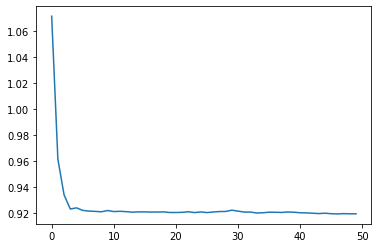

In [33]:
dataset = TwoDDataset()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

losses = []
t = trange(50)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        dist = dist_constructor(outputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss
        
        optimizer.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

Visualize the simple trained DNN

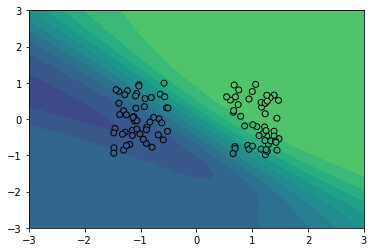

In [34]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = model(xx_tensor)
yhat = yhat[:,0].detach().cpu().numpy()

plt.contourf(X1,X2,yhat.reshape(X1.shape), levels=10, vmin=-2., vmax=2.)
plt.scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=-2, vmax=2, edgecolors='k')

### Applying SCOD
Now, we apply SCOD to the network to add uncertainty estimation

In [58]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft'
})

<class 'scod.sketching.sketched_pca.SRFT_SinglePassPCA'>


### process training dataset to compute posterior uncertainty

In [59]:
unc_model.process_dataset(dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

computing basis
using T = 304


100%|██████████| 100/100 [00:00<00:00, 210.67it/s]


### use validation dataset to optimize prior variance

In [66]:
val_dataset = TwoDDataset(split='val')
unc_model.reset_prior_scale()
unc_model.optimize_prior_scale_by_nll(val_dataset, num_epochs=10)

100%|██████████| 10/10 [00:03<00:00,  2.67it/s, eps=0.0118]


### compare SCOD's predictions to the original trained model

In [67]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = model(xx_tensor)
yhat = yhat[:,0].detach().cpu().numpy()

dists, uncs = unc_model(xx_tensor)
scod_yhat = np.array([ y.mean.detach().cpu().numpy() for y in dists])
uncs = uncs.detach().cpu().numpy()

  0%|          | 0/100 [10:15<?, ?it/s, batch_loss=-.5, eps=8.81e+4]         


Text(0.5, 1.0, 'SCOD uncertainty')

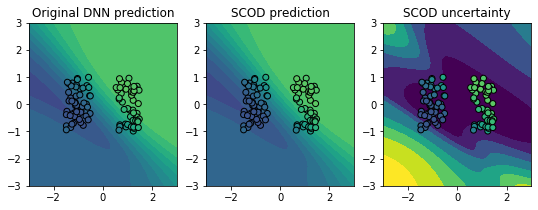

In [68]:
fig, axes = plt.subplots(1,3, figsize=[9,3])
axes[0].contourf(X1,X2,yhat.reshape(X1.shape), levels=10, vmin=-2., vmax=2.)
axes[0].scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=-2, vmax=2, edgecolors='k')
axes[0].set_title('Original DNN prediction')
axes[1].contourf(X1,X2,scod_yhat.reshape(X1.shape), levels=10, vmin=-2., vmax=2.)
axes[1].scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=-2, vmax=2, edgecolors='k')
axes[1].set_title('SCOD prediction')
axes[2].contourf(X1,X2,uncs.reshape(X1.shape), extend="both")
axes[2].scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=-2, vmax=2, edgecolors='k') #marker='x', facecolor='k', alpha=0.1)
axes[2].set_title('SCOD uncertainty')